In [24]:
import yaml
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

idx = pd.IndexSlice

In [27]:
with open(Path.cwd().parent / 'config' / 'config.yaml') as f:
    colors = yaml.safe_load(f)['plotting']['tech_colors']

root = Path.cwd().parent.parent.parent / "cluster_data" / "breyer_sweep" / "joint_data"

In [5]:
e = pd.read_csv(root / 'energy.csv', index_col=[0,1], header=list(range(9)))

In [ ]:
load_grouper = {
    "electricity": [
        'electricity',
        'industry electricity',
        'land transport EV',
        ],
    "hydrogen": [
        "H2 for industry",
        "land transport fuel cell"
        ],
    "other industry fuels": [
        'naphtha for industry',
        'solid biomass for industry',
        'gas for industry',
        ],
    "other transport fuels": [
        'shipping methanol',
        'kerosene for aviation',
        ],
    "heat": [
        "urban central heat",
        "residential urban decentral heat",
        "residential rural heat",
        "low-temperature heat for industry",
        "services rural heat",
        "services urban decentral heat",
        ],
}

nice_colors = {
    key: colors[carriers[0]] for key, carriers in load_grouper.items() for carrier in carriers
}

In [16]:
i = idx['loads']

showyear = 2040
models = [
    idx[:,:,:,:,'1990','elec','static','0.3','True'],
    idx[:,:,:,:,str(showyear),'elec','static','0.3','True'],
    idx[:,:,:,:,str(showyear),'dh','static','0.3','True'],
    idx[:,:,:,:,str(showyear),'chp','static','0.3','True'],
]

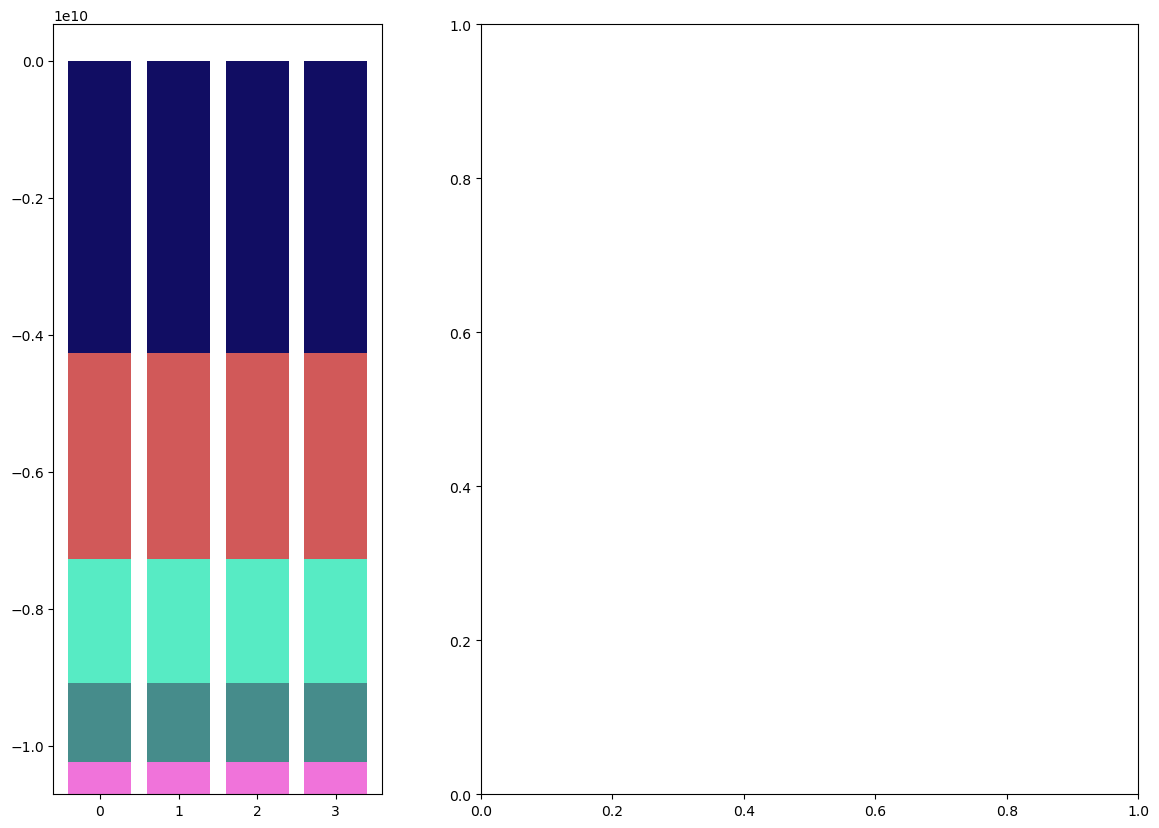

In [55]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1,2]}, figsize=(14, 10))

included = set()

for j, m in enumerate(models):
    load = e.loc[idx['loads'], m].iloc[:,0]
    nice_loads = pd.Series({nice_carr: load.loc[carriers].sum() for nice_carr, carriers in load_grouper.items()})

    if j == 0:
        order = nice_loads.sort_values(ascending=True).index
    
    nice_loads = nice_loads.loc[order]
    nice_loads_cumulative = nice_loads.cumsum()

    for nice_carr in order:

        value = nice_loads.loc[nice_carr]
        ceil = nice_loads_cumulative.loc[nice_carr]
        axs[0].bar(
            j,
            -value,
            color=nice_colors[nice_carr],
            bottom=ceil,
            )
    
plt.show()

In [56]:
nice_loads

electricity             -4.261389e+09
heat                    -3.003028e+09
other industry fuels    -1.812120e+09
other transport fuels   -1.158610e+09
hydrogen                -4.712383e+08
dtype: float64